# Preprocessing

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


from w266_common import utils, vocabulary

# Data

In [2]:
df = pd.read_csv('data/nyt_corpus.csv')
n = df.shape[0]
df.shape

(10000, 32)

In [3]:
df.columns

Index(['abstract', 'author_info', 'copyright_holder', 'copyright_year',
       'descriptor', 'desk', 'full_text', 'general_descriptor', 'headline',
       'id', 'indexing_descriptor', 'indexing_location', 'indexing_org',
       'indexing_person', 'lead_paragraph', 'length', 'length_unit',
       'normalized_byline', 'online_headline', 'online_sections',
       'print_byline', 'print_column', 'print_page_number', 'print_section',
       'publication_day_of_month', 'publication_day_of_week',
       'publication_month', 'publication_year', 'series_name',
       'taxonomic_classifier', 'title', 'types_of_material'],
      dtype='object')

### Nouns

In [8]:
from nltk.corpus import treebank

In [14]:
treebank.sents()[100]

['Alan',
 'Spoon',
 ',',
 'recently',
 'named',
 '*',
 'Newsweek',
 'president',
 ',',
 'said',
 '0',
 'Newsweek',
 "'s",
 'ad',
 'rates',
 'would',
 'increase',
 '5',
 '%',
 'in',
 'January',
 '.']

### Lemmas

### Labels

In [4]:
# possible labels - desk works best
df[['desk','general_descriptor','online_sections','taxonomic_classifier']][-10:]

,desk,general_descriptor,online_sections,taxonomic_classifier
9990,Editorial Desk,"['Budgets and Budgeting', 'National Debt (US)'...",Opinion,"['Top/Opinion', 'Top/Opinion/Opinion', 'Top/Ne..."
9991,Foreign Desk,"['Immigration and Refugees', 'Jews', 'Music', ...",World,"['Top/News', 'Top/News/World/Countries and Ter..."
9992,Foreign Desk,['Airlines and Airplanes'],NaN,['Top/Classifieds/Job Market/Job Categories/Ma...
9993,Metropolitan Desk,"['Murders and Attempted Murders', 'Basketball'...",New York and Region,"['Top/News/U.S./U.S. States, Territories and P..."
9994,Book Review Desk,['Books and Literature'],Arts; Books,"['Top/Features/Books/Book Reviews', 'Top/Featu..."
9995,Editorial Desk,NaN,Opinion,"['Top/Opinion/Opinion/Letters', 'Top/Opinion',..."
9996,National Desk,NaN,U.S.,"['Top/News/U.S.', 'Top/News']"
9997,Metropolitan Desk,NaN,New York and Region,['Top/News/New York and Region']
9998,Classified,NaN,Paid Death Notices,['Top/Classifieds/Paid Death Notices']
9999,Leisure/Weekend Desk,NaN,Arts,['Top/Features/Arts']


In [5]:
# pct nulls for each possible labels
(n - df[['desk','general_descriptor','online_sections','taxonomic_classifier']].count())/n

desk                    0.0041
general_descriptor      0.2140
online_sections         0.0244
taxonomic_classifier    0.0144
dtype: float64

In [270]:
# these will be cleaned up for the final dataframe
df.groupby('desk')['desk'].count()

desk
A Nation Challenged                                                          1
Adventure Sports                                                             2
Arts & Ideas/Cultural Desk                                                  18
Arts & Leisure Desk                                                         29
Arts and Leisure Desk                                                      129
Automobiles                                                                  9
Book Review Desk                                                           176
Business World Magazine                                                      1
Business/Finance Desk                                                        1
Business/Financial Desk                                                    628
Business\Financial Desk                                                      1
Cars                                                                         4
Circuits                                       

In [268]:
def clean_labels(c):
    c = c.str.lower().str.strip()
    c = c.str.replace('desk', '')
    c = c.str.replace(';', '')
    c = c.str.replace(' and ', ' & ')
    c = c.str.replace('\\', '/')
    c = c.str.replace('arts & .*|cultural|museums|the arts/cultural|.*weekend.*', 'arts')
    c = c.str.replace('automobiles', 'cars')
    c = c.str.replace('classifed|classifieds|job market', 'classified')
    c = c.str.replace('.*dining out.*', 'dining')
    c = c.str.replace('education.*', 'education')
    c = c.str.replace('business/financ.*|business world magazine|e-commerce|.*money.*financ.*|sundaybusiness', 'business')
    c = c.str.replace('health&fitness', 'health & fitness')
    c = c.str.replace('home|house & home/style', 'home & garden')
    c = c.str.replace('metropolitian', 'metropolitan')
    c = c.str.replace('new jersey.*', 'new jersey weekly')
    c = c.str.replace('connecticut weekly|new jersey weekly|long island weekly|the city weekly.*|westchester weekly', 'city & region weekly')
    c = c.str.replace('thursday styles|styles of the times', 'style')
    c = c.str.replace('.*design.*magazine|.*fashion.*magazine|.*style.*magazine|.*travel.*magazine|t: \w+.*', 't magazine')
    c = c.str.replace('adventure sports|sports sports', 'sports')
    c = c.str.replace('circuits|flight', 'technology')
    c = c.str.strip()
    return c

labels = pd.DataFrame(clean_labels(df.desk))
labels.groupby('desk')['desk'].count()

desk
a nation challenged                                                          1
arts                                                                       882
book review                                                                176
business                                                                   725
cars                                                                        13
city & region weekly                                                       558
classified                                                                 734
dining                                                                      47
editorial                                                                  666
education                                                                   13
escapes                                                                     18
financial                                                                 1108
foreign                                        

In [274]:
#labels.groupby('desk')['desk'].count().filter()

labels.groupby('desk').filter(lambda x: x['desk'].count() <= 10).groupby('desk')['desk'].count().count()
# >10: 28 categories with 9,936 articles
# <=10: 14 categories with 23 articles
# 41 articles with null category

14

In [9]:
df_final = pd.DataFrame(pd.concat([labels, df.full_text, df.lead_paragraph#,
                                   #df.nouns,
                                   #df.lemmas
                                  ], axis=1))
df_final.head()

,desk,full_text,lead_paragraph
0,financial,"The Bethlehem Steel Corporation, after report...","The Bethlehem Steel Corporation, after report..."
1,foreign,Seeking to raise morale at home and improve i...,Seeking to raise morale at home and improve i...
2,editorial,By the time Lord Elgin obtained the authority...,By the time Lord Elgin obtained the authority...
3,classified,SPEIER-Claire. Born New York City. Age 70. Gr...,SPEIER-Claire. Born New York City. Age 70. Gr...
4,national,LEAD: The Japanese videotape begins with the ...,LEAD: The Japanese videotape begins with the ...


In [242]:
df[df.desk == 'The Business of Green'][['desk','general_descriptor','online_sections','taxonomic_classifier']][-10:]

,desk,general_descriptor,online_sections,taxonomic_classifier
4690,The Business of Green,"['Oil (Petroleum) and Gasoline', 'Chemicals', ...",Business,"['Top/News/Business', 'Top/News/Science/Enviro..."


### Convert to Vocabulary Objects

In [196]:
from nltk.tokenize.treebank import TreebankWordTokenizer

def create_vocab(articles):
    article_list = articles.tolist()
    tokenizer = TreebankWordTokenizer()    
    token_list = [tokenizer.tokenize(a) for a in article_list if not pd.isnull(a)]
    tokens = utils.canonicalize_words(utils.flatten(token_list))
    vocab = vocabulary.Vocabulary(tokens, size=None)
    vocab.token_count = len(tokens)
        
    return vocab

In [197]:
full_text_vocab = create_vocab(df_final.full_text)
lead_paragraph_vocab = create_vocab(df_final.lead_paragraph)
#noun_vocab = create_vocab(df_final.nouns)
#lemma_vocab = create_vocab(df_final.lemmas)

In [198]:
from IPython.display import display, HTML

html = '<table><tr><th>Article Type</th><th>Vocabulary Size</th><th>Token Count</th></tr>'
html += '<tr><td>Full Text</td><td>{:,}</td>'.format(full_text_vocab.size)
html += '<td>{:,}</td></tr>'.format(full_text_vocab.token_count)
html += '<tr><td>Lead Paragraph</td><td>{:,}</td>'.format(lead_paragraph_vocab.size)
html += '<td>{:,}</td></tr>'.format(lead_paragraph_vocab.token_count)
#html += '<tr><td>Nouns</td><td>{:,}</td>'.format(noun_vocab.size)
#html += '<td>{:,}</td></tr>'.format(noun_vocab.token_count)
#html += '<tr><td>Lemmas</td><td>{:,}</td>'.format(lemma_vocab.size)
#html += '<td>{:,}</td></tr>'.format(lemma_vocab.token_count)
html += "</tr></table>"
display(HTML(html))

Article Type,Vocabulary Size,Token Count
Full Text,"144,374","6,248,228"
Lead Paragraph,"57,600","921,434"


### TFIDF Vectorize

In [294]:
def train_test_split(df, articles, labels, category_min):
    # Remove null entries
    data = df[[articles, labels]][df[articles].notnull()][df[labels].notnull()]
    data = data.reset_index()[[articles, labels]]
    
    # Remove entries in categories with too few data points
    data = data.groupby('desk').filter(lambda x: x['desk'].count() >= category_min)
    data = data.reset_index()[[articles, labels]]

    # Randomly assign indexes to train, dev, test
    rand = np.random.uniform(size=len(data[labels]))
    train_idx = np.where(rand < 0.75)[0]
    dev_idx = np.where((rand >= 0.75) & (rand < 0.8))[0]
    test_idx = np.where(rand >= 0.8)[0]
    
    # Break dataframe into train, dev, test dfs
    train = data.loc[list(train_idx)].reset_index()[[articles, labels]]
    dev = data.loc[list(dev_idx)].reset_index()[[articles, labels]]
    test = data.loc[list(test_idx)].reset_index()[[articles, labels]]
    
    return train, dev, test

In [295]:
np.random.seed(102)
ft_train, ft_dev, ft_test = train_test_split(df_final, 'full_text', 'desk', 10)
lp_train, lp_dev, lp_test = train_test_split(df_final, 'lead_paragraph', 'desk', 10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [296]:
def tfidf_vectorize(train_data, dev_data, test_data):
    tv = TfidfVectorizer()
    tv.fit(train_data)
    tv_train = tv.transform(train_data)
    tv_dev = tv.transform(dev_data)
    tv_test = tv.transform(test_data)    
    return tv_train, tv_dev, tv_test

In [297]:
# Set up sparse matrices
ft_tv_train, ft_tv_dev, ft_tv_test = tfidf_vectorize(ft_train.full_text, ft_dev.full_text, ft_test.full_text)
lp_tv_train, lp_tv_dev, lp_tv_test = tfidf_vectorize(lp_train.lead_paragraph, lp_dev.lead_paragraph, lp_dev.lead_paragraph)

In [385]:
html = '<table><th>Article Type</th><th>Training Articles</th><th>Training Vocab Size</th><th>Training NNZ per Article</th>'
html += '<th>Dev Articles</th><th>Test Articles</th></tr>'
html += '<tr><td>Full Text</td><td>{:,}</td><td>{:,}</td><td>{:,.0f}</td>'.format(ft_tv_train.shape[0], ft_tv_train.shape[1], ft_tv_train.nnz / ft_tv_train.shape[0])
html += '<td>{:,}</td><td>{:,}</td></tr>'.format(ft_tv_dev.shape[0], ft_tv_test.shape[0])
html += '<tr><td>Lead Paragraph</td><td>{:,}</td><td>{:,}</td><td>{:,.0f}</td>'.format(lp_tv_train.shape[0], lp_tv_train.shape[1], lp_tv_train.nnz / lp_tv_train.shape[0])
html += '<td>{:,}</td><td>{:,}</td></tr>'.format(lp_tv_dev.shape[0], lp_tv_test.shape[0])
html += '</tr></table>'
display(HTML(html))

Full Text,"7,302","85,031",260,512,"1,969"
Lead Paragraph,"7,076","39,378",61,484,484


In [414]:
def log_reg(train_data, train_labels, dev_data, dev_labels, C):
    penalties = ['l1','l2']
    accuracy = []
    for i in penalties:
        for j in range(len(C)):
            lr = LogisticRegression(C=C[j], penalty=i)
            lr.fit(train_data, train_labels)
            accuracy.append(lr.score(dev_data, dev_labels))
    
    # Combine to dataframe
    pd.options.display.float_format = '{:,.8f}'.format
    df = pd.concat([pd.DataFrame(['L1']*len(C) + ['L2']*len(C), columns={'penalty'}),
                    pd.DataFrame(C*len(penalties), columns={'C'}), pd.DataFrame(accuracy, columns={'accuracy'})], axis=1)
    return df

C = list(10. ** np.arange(-8, 8))
ft_lr = log_reg(ft_tv_train, ft_train.desk, ft_tv_dev, ft_dev.desk, C)
lp_lr = log_reg(lp_tv_train, lp_train.desk, lp_tv_dev, lp_dev.desk, C)

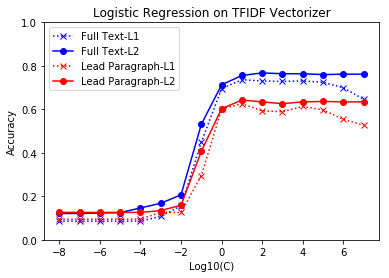

In [418]:
# Plot logistic regression accuracies
log_C = np.log10(C)
plt.plot(log_C, ft_lr.accuracy[np.where(ft_lr.penalty == 'L1')[0]],
        color='blue', linestyle='dotted', marker='x', label='Full Text-L1')
plt.plot(log_C, ft_lr.accuracy[np.where(ft_lr.penalty == 'L2')[0]],
        color='blue', marker='o', label='Full Text-L2')
plt.plot(log_C, lp_lr.accuracy[np.where(lp_lr.penalty == 'L1')[0]],
        color='red', linestyle='dotted', marker='x', label='Lead Paragraph-L1')
plt.plot(log_C, lp_lr.accuracy[np.where(lp_lr.penalty == 'L2')[0]],
        color='red', marker='o', label='Lead Paragraph-L2')
plt.title('Logistic Regression on TFIDF Vectorizer')
plt.xlabel('Log10(C)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

In [408]:
ft_lr.iloc[np.where(ft_lr.accuracy == max(ft_lr.accuracy))[0][0]]

penalty           L2
C          100.00000
accuracy     0.76758
Name: 26, dtype: object

In [410]:
def multi_nb(train_data, train_labels, dev_data, dev_labels, alpha):
    accuracy = []
    for i in range(len(alpha)):
        mnb = MultinomialNB(alpha=alpha[i])
        mnb.fit(train_data, train_labels)
        accuracy.append(mnb.score(dev_data, dev_labels))
    
    # Combine to dataframe
    pd.options.display.float_format = '{:,.5f}'.format
    df = pd.concat([pd.DataFrame(alpha, columns={'alpha'}), pd.DataFrame(accuracy, columns={'accuracy'})], axis=1)
    return df

alpha = list(2. ** np.arange(-10, 5, 0.5))
ft_mnb = multi_nb(ft_tv_train, ft_train.desk, ft_tv_dev, ft_dev.desk, alpha)
lp_mnb = multi_nb(lp_tv_train, lp_train.desk, lp_tv_dev, lp_dev.desk, alpha)

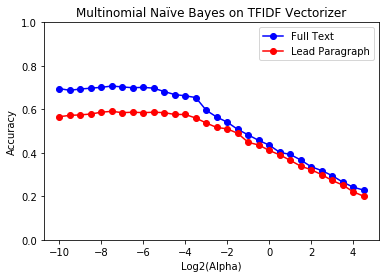

In [421]:
# Plot multinomial accuracies
log_alpha = np.log2(alpha)
plt.plot(log_alpha, ft_mnb.accuracy, color='blue', marker='o', label='Full Text')
plt.plot(log_alpha, lp_mnb.accuracy, color='red', marker='o', label='Lead Paragraph')
plt.title('Multinomial Naïve Bayes on TFIDF Vectorizer')
plt.xlabel('Log2(Alpha)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

In [406]:
ft_mnb.iloc[np.where(ft_mnb.accuracy == max(ft_mnb.accuracy))[0][0]]

alpha      0.00552
accuracy   0.70703
Name: 5, dtype: float64